In [1]:
pip install keras_unet_collection

In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [4]:
import zipfile
import os
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
import warnings
warnings.filterwarnings('ignore')
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import re
from keras_unet_collection import models, losses
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Accuracy
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

In [5]:
data_path = "C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg"

In [6]:
haze_files = glob(pathname = data_path+'\\hazy\\*')
haze_files[:1]

['C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\hazy\\frm_1 (1).jpg']

In [7]:
clear_files = []

for path in haze_files:
    filename = os.path.basename(path)
    new_filename = re.sub(r'frm_\d+ ', '', filename)
    new_directory = os.path.dirname(path).replace("hazy", "clear") + "\\" + "\\"
    new_path = os.path.join(new_directory, new_filename)
    clear_files.append(new_path)

In [8]:
clear_files

['C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\clear\\\\(1).jpg',
 'C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\clear\\\\(10).jpg',
 'C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\clear\\\\(100).jpg',
 'C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\clear\\\\(1000).jpg',
 'C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\clear\\\\(10000).jpg',
 'C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\clear\\\\(10001).jpg',
 'C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\clear\\\\(10002).jpg',
 'C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\clear\\\\(10003).jpg',
 'C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\clear\\\\(10004).jpg',
 'C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\clear\\\\(10005).jpg',
 'C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\clear\\\\(10006).jpg',
 'C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\clear\\\\(10007).jpg',
 'C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\clear\\\\(10008).jpg',
 'C:\\Users\\Admin\\Birva_reside_minorP\\ALL-mrg\\clear\\\\(1

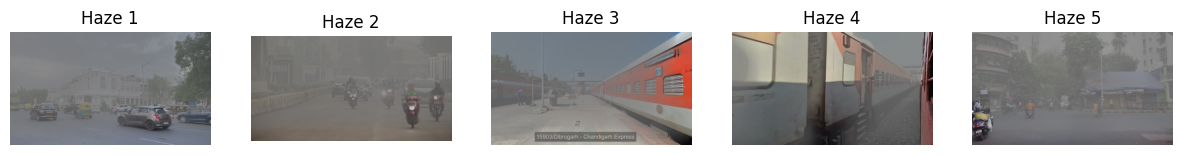

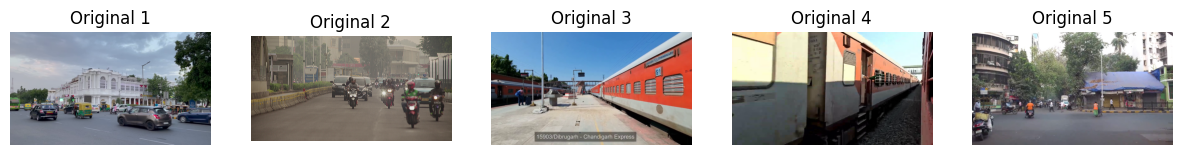

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    haze_img = cv2.imread(haze_files[i])
    haze_img_rgb = cv2.cvtColor(haze_img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(haze_img_rgb)
    axes[i].axis('off')
    axes[i].set_title(f'Haze {i+1}')

plt.show()

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    img = cv2.imread(clear_files[i])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img_rgb)
    axes[i].axis('off')
    axes[i].set_title(f'Original {i+1}')

plt.show()

In [10]:
df = pd.DataFrame( data = {
    'haze_train': haze_files,
    'images': clear_files
})
df

,haze_train,images
0,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\haz...,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\cle...
1,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\haz...,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\cle...
2,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\haz...,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\cle...
3,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\haz...,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\cle...
4,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\haz...,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\cle...
...,...,...
65335,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\haz...,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\cle...
65336,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\haz...,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\cle...
65337,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\haz...,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\cle...
65338,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\haz...,C:\Users\Admin\Birva_reside_minorP\ALL-mrg\cle...


In [11]:
data_path_dense = "C:\\Users\\Admin\\Birva_reside_minorP\\Dense_Haze_NTIRE19"

In [12]:
haze_dense_files = glob(pathname = data_path_dense+'\\*_hazy*')
haze_dense_files[:1]

['C:\\Users\\Admin\\Birva_reside_minorP\\Dense_Haze_NTIRE19\\01_hazy.png']

In [13]:
image_dense_files = []

for i in haze_dense_files:
    image_dense_files.append(i.replace('hazy', 'GT'))

In [14]:
df_dense = pd.DataFrame( data = {
    'haze_train': haze_dense_files,
    'images': image_dense_files
})

In [15]:
#data_path_outdoor = "C:\\Users\\Admin\\Birva_reside_minorP\\arjun haze dataset\\outdoor-video\\outdoor-video"

In [16]:
# haze_files_outdoor = glob(pathname = data_path_outdoor+'\\hazy\\*')
# haze_files_outdoor[:1]

In [17]:
# clear_files_outdoor = []

# for input_path in haze_files_outdoor:
#     dir_path, file_name = os.path.split(input_path)
#     file_name_no_ext, ext = os.path.splitext(file_name)
#     dir_path = dir_path.replace('hazy', 'clear')
#     parts = file_name_no_ext.split('_')
#     desired_part = "_".join(parts[-4:]) 
#     desired_part = desired_part.replace('_synt', '') 
#     desired_part = desired_part.replace('merge-outputs_', '') 
#     desired_part = desired_part.replace('.jpg', '')
#     output_filename = f"{desired_part}.jpg"
#     output_path = os.path.join(dir_path, output_filename)
#     clear_files_outdoor.append(output_path)
    
# clear_files_outdoor[:1]

In [18]:
# modified_paths = []

# for path in clear_files_outdoor:
#     parts = path.split('\\')
#     filename = parts[-1]
#     prefix = filename.split('_')[0]
#     modified_filename = f"{prefix}_{filename}"
#     modified_path = '\\'.join(parts[:-1] + [modified_filename])
#     modified_paths.append(modified_path)

# print(modified_paths[:1])

In [19]:
# data_path_indoor = "C:\\Users\\Admin\\Birva_reside_minorP\\arjun haze dataset\\indoor-images\\indoor-images"

In [20]:
# haze_files_indoor = glob(pathname = data_path_indoor+'\\hazy\\*')
# haze_files_indoor[:1]

In [21]:
# clear_files_indoor = []

# for input_path in haze_files_indoor:
#     dir_path, file_name = os.path.split(input_path)
#     file_name_no_ext, ext = os.path.splitext(file_name)
#     dir_path = dir_path.replace('hazy', 'clear')
#     parts = file_name_no_ext.split('_')
#     desired_number = parts[-2]  
#     output_path = os.path.join(dir_path, f"{desired_number}.jpg")
#     clear_files_indoor.append(output_path)
# clear_files_indoor[:1]

In [22]:
# fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# for i in range(5):
#     haze_img = cv2.imread(haze_files_indoor[i])
#     haze_img_rgb = cv2.cvtColor(haze_img, cv2.COLOR_BGR2RGB)
#     axes[i].imshow(haze_img_rgb)
#     axes[i].axis('off')
#     axes[i].set_title(f'Haze {i+1}')

# plt.show()

# fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# for i in range(5):
#     img = cv2.imread(clear_files_indoor[i])
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     axes[i].imshow(img_rgb)
#     axes[i].axis('off')
#     axes[i].set_title(f'Original {i+1}')

# plt.show()

In [23]:
# fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# for i in range(5):
#     haze_img = cv2.imread(haze_files_outdoor[i])
#     haze_img_rgb = cv2.cvtColor(haze_img, cv2.COLOR_BGR2RGB)
#     axes[i].imshow(haze_img_rgb)
#     axes[i].axis('off')
#     axes[i].set_title(f'Haze {i+1}')

# plt.show()

# fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# for i in range(5):
#     img = cv2.imread(modified_paths[i])
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     axes[i].imshow(img_rgb)
#     axes[i].axis('off')
#     axes[i].set_title(f'Original {i+1}')

# plt.show()

In [24]:
# df_indoor = pd.DataFrame( data = {
#     'haze_train': haze_files_indoor,
#     'images': clear_files_indoor
# })
# df_indoor

In [25]:
# df_indoor = df_indoor[df_indoor['images'] != '/kaggle/input/haze-images-indoor-outdoor/indoor-images/indoor-images/clear/12.jpg']
# df_indoor

In [26]:
# df_outdoor = pd.DataFrame( data = {
#     'haze_train': haze_files_outdoor,
#     'images': modified_paths
# })
# df_outdoor

In [27]:
# df = pd.concat([df_indoor, df_outdoor], ignore_index=True)

In [28]:
df.shape

(65340, 2)

In [29]:
df_train_out, df_test_out = train_test_split(df, test_size = 0.20)

print(df_train_out.shape)
print(df_test_out.shape)

(52272, 2)
(13068, 2)


In [30]:
df_train_dense, df_test_dense = train_test_split(df_dense, test_size = 0.18)

print(df_train_dense.shape)
print(df_test_dense.shape)

(45, 2)
(10, 2)


In [31]:
df_train = pd.concat([df_train_out, df_train_dense], ignore_index=True)

In [32]:
df_test = pd.concat([df_test_out, df_test_dense], ignore_index=True)

In [33]:
def center_crop(image, crop_size=(512, 512)):
    height, width = image.shape[:2]
    left = (width - crop_size[0]) // 2
    top = (height - crop_size[1]) // 2
    right = (width + crop_size[0]) // 2
    bottom = (height + crop_size[1]) // 2
    cropped_image = image[top:bottom, left:right]
    return cropped_image

In [34]:
def load_and_preprocess_image(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_crop = center_crop(img_rgb)
    img_scaled = image_crop.astype(np.float32) / 255.0
    return img_scaled

In [35]:
def generate_data_generator(dataframe, batch_size=8):
    num_samples = len(dataframe)
    while True:
        batch_haze = []
        batch_images = []
        while len(batch_haze) < batch_size:
            idx = np.random.randint(0, num_samples)
            haze_path = dataframe.iloc[idx]['haze_train']
            haze_img = cv2.imread(haze_path)
            original_path = dataframe.iloc[idx]['images']
            original_img = cv2.imread(original_path)
            
            if haze_img is None or original_img is None:
                continue
                
            if haze_img.shape[0] >= 512 and haze_img.shape[1] >= 512:  
                haze_img_crop = load_and_preprocess_image(haze_img)
                original_img_crop = load_and_preprocess_image(original_img)
                
                batch_haze.append(haze_img_crop)
                batch_images.append(original_img_crop)
                
        yield np.array(batch_haze), np.array(batch_images)

In [36]:
'''def generate_data_generator(dataframe, batch_size=8):
    num_samples = len(dataframe)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_haze = []
        batch_images = []
        for idx in indices:
            haze_img = load_and_preprocess_image(dataframe.iloc[idx]['haze_train'])
            original_img = load_and_preprocess_image(dataframe.iloc[idx]['images'])
            batch_haze.append(haze_img)
            batch_images.append(original_img)
        
        yield np.array(batch_haze), np.array(batch_images)'''

"def generate_data_generator(dataframe, batch_size=8):\n    num_samples = len(dataframe)\n    while True:\n        indices = np.random.randint(0, num_samples, batch_size)\n        batch_haze = []\n        batch_images = []\n        for idx in indices:\n            haze_img = load_and_preprocess_image(dataframe.iloc[idx]['haze_train'])\n            original_img = load_and_preprocess_image(dataframe.iloc[idx]['images'])\n            batch_haze.append(haze_img)\n            batch_images.append(original_img)\n        \n        yield np.array(batch_haze), np.array(batch_images)"

In [37]:
'''indices = np.random.randint(0, 1, 1)
batch_haze = []
batch_images = []
for idx in indices:
    haze_img = load_and_preprocess_image(df_train.iloc[idx]['haze_train'])
    original_img = load_and_preprocess_image(df_train.iloc[idx]['images'])
    batch_haze.append(haze_img)
    batch_images.append(original_img)
np.array(batch_haze).shape'''

"indices = np.random.randint(0, 1, 1)\nbatch_haze = []\nbatch_images = []\nfor idx in indices:\n    haze_img = load_and_preprocess_image(df_train.iloc[idx]['haze_train'])\n    original_img = load_and_preprocess_image(df_train.iloc[idx]['images'])\n    batch_haze.append(haze_img)\n    batch_images.append(original_img)\nnp.array(batch_haze).shape"

In [38]:
batch_size = 8
train_generator = generate_data_generator(df_train, batch_size=batch_size)
test_generator = generate_data_generator(df_test, batch_size=batch_size)

In [39]:
def ssim_loss(y_true, y_pred):
    return 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def ssim(y_true, y_pred):

     return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [40]:
'''model = models.unet_2d((None,None,3), filter_num = [16,16,16,16,16],
               n_labels = 3,
               stack_num_down = 2, stack_num_up = 2,
               activation = 'ReLU',
               output_activation = 'Sigmoid',
               pool=False, unpool=False,
               batch_norm = True)'''

"model = models.unet_2d((None,None,3), filter_num = [16,16,16,16,16],\n               n_labels = 3,\n               stack_num_down = 2, stack_num_up = 2,\n               activation = 'ReLU',\n               output_activation = 'Sigmoid',\n               pool=False, unpool=False,\n               batch_norm = True)"

In [41]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model

def custom_unet(input_shape, filter_num, n_labels, stack_num_down, stack_num_up, activation='ReLU', output_activation='Sigmoid', pool=False, unpool=False, batch_norm=True):
    inputs = Input(shape=input_shape)

    encoder_blocks = []
    decoder_blocks = []

    x = inputs
    for i in range(stack_num_down):
        x = Conv2D(filter_num[i], (3, 3), activation=None, padding='same')(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        encoder_blocks.append(x)
        if pool:
            x = MaxPooling2D((2, 2))(x)

    x = Conv2D(filter_num[stack_num_down], (3, 3), activation=None, padding='same')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)

    for i in range(stack_num_up):
        if unpool:
            x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, encoder_blocks[-(i + 1)]])
        x = Conv2D(filter_num[stack_num_down + i], (3, 3), activation=None, padding='same')(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        x = Conv2D(filter_num[stack_num_down + i], (3, 3), activation=None, padding='same')(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        decoder_blocks.append(x)

    outputs = Conv2D(n_labels, (1, 1), activation=output_activation)(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [42]:
input_shape = (None, None, 3)
filter_num = [4, 8, 16, 32, 64]
n_labels = 3
stack_num_down = 2
stack_num_up = 2
activation = 'relu'
output_activation = 'sigmoid'
pool = False
unpool = False
batch_norm = True

In [43]:
model = custom_unet(input_shape, filter_num, n_labels, stack_num_down, stack_num_up, activation, output_activation, pool, unpool, batch_norm)

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   112         ['input_1[0][0]']                
                                4)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   16         ['conv2d[0][0]']                 
 alization)                     4)                                                            

In [45]:
filepath = "C:\\Users\\Admin\\Birva_reside_minorP\\best_model_w_o_resize.keras"

checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_ssim',
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

In [46]:
model.compile(optimizer='adam', loss=ssim_loss, metrics=[ssim])

In [47]:
epochs=3

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(df_train) // batch_size,
    epochs=epochs,
    callbacks=[checkpoint],
    validation_data=test_generator,
    validation_steps=len(df_test) // batch_size
)

Epoch 1/3
 641/6539 [=>............................] - ETA: 32:16 - loss: 0.1658 - ssim: 0.8342

In [ ]:
history_training = history.history
train_loss_list = history_training['loss']
test_loss_list = history_training['val_loss']

plt.plot(test_loss_list, 'b-', label='Test Loss')
plt.plot(train_loss_list, 'r-', label='Train Loss')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)
plt.legend()
plt.show()

In [ ]:
for i in range(10):
    img = cv2.imread(df_test['haze_train'].iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img2 = cv2.imread(df_test['images'].iloc[i]) 
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    h_img = img
    o_img = img2
    #img = center_crop(img)
    
    img = img.astype(np.float32) / 255.0
    #img2 = center_crop(img2)
    #img2 = cv2.resize(img2, (256,256)) 
    #img = cv2.resize(img, (256,256))
    #img = img/255.0
    img = img[np.newaxis, : ,:, :]
    pred_img = model.predict(img)
    #X_test.append(np.squeeze(pred_img.astype(np.float32)))

    #img_non_haze_restored = hist_match(img2, np.squeeze(pred_img))
    plt.figure(figsize=(12, 6))
    
    # Plotting first row
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(h_img))
    plt.title("Original Haze Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(o_img))
    plt.title("Original Clear Image")
    
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img))
    plt.title("Predicted Image")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
#     plt.savefig('Originals_vs_Predictions_{}.png'.format(i))

In [ ]:
data_path_test = "C:\\Users\\Admin\\Birva_reside_minorP\\Dense_Haze_NTIRE19"

In [ ]:
haze_test_files = glob(pathname = data_path_test+'\\*_hazy*')
haze_test_files[:1]

In [ ]:
image_test_files = []

for i in haze_test_files:
    image_test_files.append(i.replace('hazy', 'GT'))

In [ ]:
df_check = pd.DataFrame( data = {
    'haze_train': haze_test_files,
    'images': image_test_files
})

In [ ]:
for i in range(len(df_check)):
    img = cv2.imread(df_check['haze_train'].iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img2 = cv2.imread(df_check['images'].iloc[i]) 
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    h_img = img
    o_img = img2
    #img = center_crop(img)
    img = img.astype(np.float32) / 255.0
    #img2 = center_crop(img2)
    #img2 = cv2.resize(img2, (256,256)) 
    #img = cv2.resize(img, (256,256))
    #img = img/255.0
    img = img[np.newaxis, : ,:, :]
    pred_img = model.predict(img)
    #X_test.append(np.squeeze(pred_img.astype(np.float32)))

    #img_non_haze_restored = hist_match(img2, np.squeeze(pred_img))
    plt.figure(figsize=(12, 6))
    
    # Plotting first row
    plt.subplot(2, 3, 1)
    plt.imshow(np.squeeze(h_img))
    plt.title("Original Haze Image")
    
    plt.subplot(2, 3, 2)
    plt.imshow(np.squeeze(o_img))
    plt.title("Original Clear Image")
    
    # Plotting second row
    plt.subplot(2, 3, 4)
    plt.imshow(np.squeeze(img*255).astype(np.uint8))
    plt.title("Crop Haze Image")
    plt.axis('off')
    
    plt.subplot(2, 3, 5)
    plt.imshow(np.squeeze(img2))
    plt.title("Crop Clear Image")
    plt.axis('off')
    
    plt.subplot(2, 3, 6)
    plt.imshow(np.squeeze(pred_img))
    plt.title("Crop Predicted Image")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    plt.savefig('Originals_vs_Predictions_{}.png'.format(i))

In [ ]:
video_path = "C:\\Users\\Admin\\Birva_reside_minorP\\Delhi Haze Video.mp4"
cap = cv2.VideoCapture(video_path)

In [ ]:
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [ ]:
frame_width

In [ ]:
frame_height

In [ ]:
fps

In [ ]:
total_frames

In [ ]:
out = cv2.VideoWriter("C:\\Users\\Admin\\Birva_reside_minorP\\clear_video_3.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

In [ ]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
        
    #frame_crop = center_crop(frame)
    frame_scaled = frame.astype(np.float32) / 255.0
    
    img = frame_scaled[np.newaxis, : ,:, :]
    pred_img = model.predict(img)
    pred_img = (pred_img.squeeze() * 255).astype(np.uint8)
    #plt.imshow('Processed Frame', pred_img)
    out.write(pred_img)
    
cap.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
5+2